In [35]:
# Установка transformers
!pip install transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [36]:
#Установка catboost
!pip install catboost

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [37]:
import pandas as pd
from itertools import groupby

In [38]:
#import необходимых модулей

import pandas as pd
#from ludwig.api import LudwigModel
#from ludwig.visualize import learning_curves
import yaml
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

import numpy as np
from datetime import datetime, timedelta

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

In [39]:
#Считывание данных в DataFrame 

train= pd.read_csv('/kaggle/input/vladivostok2022/train_predobr.csv', sep=';', index_col=None)
test= pd.read_csv('/kaggle/input/vladivostok2022/test_predobr.csv', sep=';', index_col=None)
tabliza= pd.read_csv('/kaggle/input/vladivostok2022/tabliza.csv', sep=';', index_col=None)

In [40]:
train=train.merge(tabliza, how="left", on="overall_worklogs")

In [41]:
# сокращаем трейн по уровню выше 7200 для более эффективного разделения наибольших
train=train.loc[train['overall_worklogs']>7200]
train

,project_id,Id_razn,mean_words_comment,count_comments,id,assignee_id,creator_id,overall_worklogs,summary_to_eng,Year,Month,Day,Hour,DayOfWeek,Mesto_in_project,Text_Summa,overall_worklogs_num,id|Количество
2,5,0,0.0,0,819947,93,93,14400,"UI tests of the section ""Personal account""",2019,10,1,6,2,0.038462,"UI tests of the section ""Personal account""",189,224
7,5,475,16.0,2,819933,207,1,7800,Make a division by mobile operators,2019,10,1,6,2,0.153846,Make a division by mobile operators Added the ...,104,83
10,5,17,30.0,2,819924,264,207,17580,Doesn't work with cdr_calc_durations,2019,10,1,8,2,0.230769,Doesn't work with cdr_calc_durations [~mursidi...,217,1
11,5,0,0.0,0,819921,94,94,22500,Fix crash addons (NegativeArraySizeException),2019,10,1,11,2,0.250000,Fix crash addons (NegativeArraySizeException),260,31
15,5,0,0.0,0,819910,1,1,9000,Checking the client's balance when changing th...,2019,10,2,13,3,0.326923,Checking the client's balance when changing th...,119,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9570,48,0,0.0,0,688457,1,1,11880,Investigate ANTMAN and find working CODs,2020,6,12,18,5,5.113941,Investigate ANTMAN and find working CODs,164,2
9582,48,0,62.0,1,688422,1,1,67080,Fix update script bug with JackfruitUsers,2020,6,12,20,5,5.194370,Fix update script bug with JackfruitUsers Comm...,486,1
9583,48,0,11.0,1,688417,1,116,14400,Teachers page returns 500 error,2020,6,15,9,1,5.207775,Teachers page returns 500 error fixed. This is...,189,224
9584,48,0,0.0,0,688414,1,116,26040,Make a test to check teachers pages for VN & TH,2020,6,15,9,1,5.214477,Make a test to check teachers pages for VN & TH,290,1


In [42]:
test

,Id_razn,mean_words_comment,count_comments,project_id,Mesto_in_project,id,Year,Month,Day,Hour,DayOfWeek,assignee_id,creator_id,summary_to_eng,Text_Summa
0,478,62.000000,8,5,8.884615,675975,2020,1,15,9,3,112,112,Download all mp3 files of calls to disk,Download all mp3 files of calls to disk Resear...
1,721,16.500000,4,5,8.903846,675972,2020,1,15,9,3,112,112,Delete mp3 call files from the server before 0...,Delete mp3 call files from the server before 0...
2,0,7.000000,1,5,8.961538,675965,2020,1,16,4,4,94,54,Remove the tariff selection window and transfe...,Remove the tariff selection window and transfe...
3,180,41.500000,2,5,9.000000,675961,2020,1,16,11,4,94,94,"During authorization, the user/driver does not...","During authorization, the user/driver does not..."
4,3367,47.571429,7,5,9.076923,675955,2020,1,17,5,5,1,54,The main problems for corp. department (as of ...,The main problems for corp. department (as of ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,0,3.000000,1,48,9.323056,702545,2020,9,24,11,4,1,1,Order to fix: audit result & save root cause,Order to fix: audit result & save root cause q...
1066,33,12.600000,10,48,9.390080,702528,2020,9,28,14,1,1,1,Lỗi EPC không tải trang được,Lỗi EPC không tải trang được [~hungcm] anh ơi ...
1067,0,0.000000,0,48,9.524129,702499,2020,10,6,13,2,1,1,Line red cannot calling out from system: Audit...,Line red cannot calling out from system: Audit...
1068,0,0.000000,0,48,10.000000,702376,2020,11,5,15,4,1,1,ipphone problem: push & audit result,ipphone problem: push & audit result


In [43]:
train.columns

Index(['project_id', 'Id_razn', 'mean_words_comment', 'count_comments', 'id',
       'assignee_id', 'creator_id', 'overall_worklogs', 'summary_to_eng',
       'Year', 'Month', 'Day', 'Hour', 'DayOfWeek', 'Mesto_in_project',
       'Text_Summa', 'overall_worklogs_num', 'id|Количество'],
      dtype='object')

In [44]:
train['overall_worklogs_binary']=0
train.loc[(train['overall_worklogs']>68000),'overall_worklogs_binary']=1

In [45]:
train['overall_worklogs_binary'].value_counts()

0    3982
1     291
Name: overall_worklogs_binary, dtype: int64

In [46]:
column_names_to_train =['project_id', 'Id_razn', 'mean_words_comment', 'count_comments',
       'assignee_id', 'creator_id', 
       'Year', 'Month', 'Day', 'Hour', 'DayOfWeek', 'Mesto_in_project']

column_names_to_linear =['mean_words_comment','count_comments','Id_razn','Mesto_in_project']

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4273 entries, 2 to 9585
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   project_id               4273 non-null   int64  
 1   Id_razn                  4273 non-null   int64  
 2   mean_words_comment       4273 non-null   float64
 3   count_comments           4273 non-null   int64  
 4   id                       4273 non-null   int64  
 5   assignee_id              4273 non-null   int64  
 6   creator_id               4273 non-null   int64  
 7   overall_worklogs         4273 non-null   int64  
 8   summary_to_eng           4273 non-null   object 
 9   Year                     4273 non-null   int64  
 10  Month                    4273 non-null   int64  
 11  Day                      4273 non-null   int64  
 12  Hour                     4273 non-null   int64  
 13  DayOfWeek                4273 non-null   int64  
 14  Mesto_in_project        

In [48]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id_razn             1070 non-null   int64  
 1   mean_words_comment  1070 non-null   float64
 2   count_comments      1070 non-null   int64  
 3   project_id          1070 non-null   int64  
 4   Mesto_in_project    1070 non-null   float64
 5   id                  1070 non-null   int64  
 6   Year                1070 non-null   int64  
 7   Month               1070 non-null   int64  
 8   Day                 1070 non-null   int64  
 9   Hour                1070 non-null   int64  
 10  DayOfWeek           1070 non-null   int64  
 11  assignee_id         1070 non-null   int64  
 12  creator_id          1070 non-null   int64  
 13  summary_to_eng      1070 non-null   object 
 14  Text_Summa          1070 non-null   object 
dtypes: float64(2), int64(11), object(2)
memory usage: 125.5

In [49]:
train_all=pd.concat([train, test])
train_all

,project_id,Id_razn,mean_words_comment,count_comments,id,assignee_id,creator_id,overall_worklogs,summary_to_eng,Year,Month,Day,Hour,DayOfWeek,Mesto_in_project,Text_Summa,overall_worklogs_num,id|Количество,overall_worklogs_binary
2,5,0,0.0,0,819947,93,93,14400.0,"UI tests of the section ""Personal account""",2019,10,1,6,2,0.038462,"UI tests of the section ""Personal account""",189.0,224.0,0.0
7,5,475,16.0,2,819933,207,1,7800.0,Make a division by mobile operators,2019,10,1,6,2,0.153846,Make a division by mobile operators Added the ...,104.0,83.0,0.0
10,5,17,30.0,2,819924,264,207,17580.0,Doesn't work with cdr_calc_durations,2019,10,1,8,2,0.230769,Doesn't work with cdr_calc_durations [~mursidi...,217.0,1.0,0.0
11,5,0,0.0,0,819921,94,94,22500.0,Fix crash addons (NegativeArraySizeException),2019,10,1,11,2,0.250000,Fix crash addons (NegativeArraySizeException),260.0,31.0,0.0
15,5,0,0.0,0,819910,1,1,9000.0,Checking the client's balance when changing th...,2019,10,2,13,3,0.326923,Checking the client's balance when changing th...,119.0,216.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,48,0,3.0,1,702545,1,1,NaN,Order to fix: audit result & save root cause,2020,9,24,11,4,9.323056,Order to fix: audit result & save root cause q...,NaN,NaN,NaN
1066,48,33,12.6,10,702528,1,1,NaN,Lỗi EPC không tải trang được,2020,9,28,14,1,9.390080,Lỗi EPC không tải trang được [~hungcm] anh ơi ...,NaN,NaN,NaN
1067,48,0,0.0,0,702499,1,1,NaN,Line red cannot calling out from system: Audit...,2020,10,6,13,2,9.524129,Line red cannot calling out from system: Audit...,NaN,NaN,NaN
1068,48,0,0.0,0,702376,1,1,NaN,ipphone problem: push & audit result,2020,11,5,15,4,10.000000,ipphone problem: push & audit result,NaN,NaN,NaN


In [50]:


train_all['project_id']=train_all['project_id'].astype("category").cat.codes
train_all['assignee_id']=train_all['assignee_id'].astype("category").cat.codes
train_all['creator_id']=train_all['creator_id'].astype("category").cat.codes
train_all['Year']=train_all['Year'].astype("category").cat.codes
train_all['Month']=train_all['Month'].astype("category").cat.codes
train_all['Day']=train_all['Day'].astype("category").cat.codes
train_all['Hour']=train_all['Hour'].astype("category").cat.codes
train_all['DayOfWeek']=train_all['DayOfWeek'].astype("category").cat.codes

#train[column_names_to_linear]=np.log(1+train[column_names_to_linear])

In [51]:
test=test[['id']]
test_all = test.merge(train_all, how='left', on='id')

In [52]:
train=train[['id']]
train_all = train.merge(train_all, how='left', on='id')

In [53]:
# Обучение разделению более 68000 сек
xgb_estimator = xgb.XGBClassifier(
    learning_rate =0.015,
     n_estimators=2000,
     max_depth=16,
     min_child_weight=6,
     gamma=0,
     verbosity=2,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:hinge',
     nthread=4,
     tree_method='approx',#,gpu_id=0, 
           #predictor='gpu_predictor',
    enable_categorical=True, 
    use_label_encoder=False,
     max_cat_to_onehot =1000,
     eval_metric='error',
     seed=93,
     feature_fraction=0.7,
        scale_pos_weight=20)

In [54]:
%%time
# fit first model
xgb_estimator.fit(train_all[column_names_to_train], train_all['overall_worklogs_binary'])

[18:37:31] WARNING: ../src/learner.cc:541: 
Parameters: { enable_categorical, feature_fraction, max_cat_to_onehot, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=15
[18:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=16
[18:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=16
[18:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=14
[18:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=16
[18:37:31] INFO: ../src/tree/upd

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, enable_categorical=True,
              eval_metric='error', feature_fraction=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.015, max_cat_to_onehot=1000, max_delta_step=0,
              max_depth=16, min_child_weight=6, missing=nan,
              monotone_constraints='()', n_estimators=2000, n_jobs=4, nthread=4,
              num_parallel_tree=1, objective='binary:hinge', random_state=93,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=20, seed=93,
              subsample=0.8, ...)

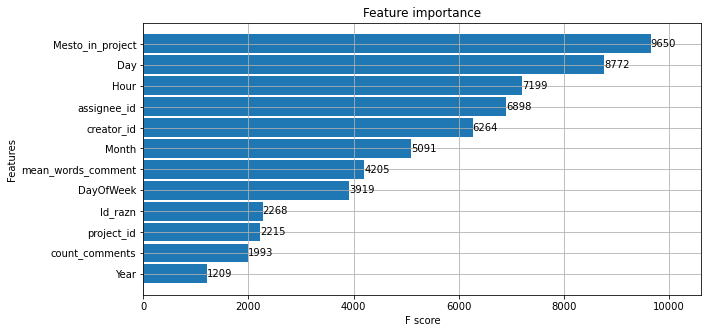

In [55]:
# Важность признаков XGBoost
# 
_ = plot_importance(xgb_estimator, height=0.9)

In [56]:
# Проверка на трейне
predictions = xgb_estimator.predict(train_all[column_names_to_train])

f1_score(train_all['overall_worklogs_binary'], predictions, average='macro', zero_division = 0)

0.9765411833169548

In [57]:
# проверка на тесте
predictions_fin= xgb_estimator.predict(test_all[column_names_to_train])
test_all['overall_worklogs_binary_xgboost']=predictions_fin
test_all['overall_worklogs_binary_xgboost'].value_counts()

0    951
1    119
Name: overall_worklogs_binary_xgboost, dtype: int64

In [58]:
# выбираем поля для нейросети СatBoost по бинарной классификации

X_train=train_all[['project_id', 'assignee_id', 'creator_id', 'summary_to_eng',
        'Year', 'Month', 'Day', 'Hour', 'DayOfWeek', 'Mesto_in_project',
       'Id_razn', 'mean_words_comment', 'count_comments','Text_Summa' ]]
y_train=train_all[['overall_worklogs_binary']]


testnet=test_all[['project_id', 'assignee_id', 'creator_id', 'summary_to_eng',
        'Year', 'Month', 'Day', 'Hour', 'DayOfWeek','Mesto_in_project',
       'Id_razn', 'mean_words_comment', 'count_comments','Text_Summa' ]]

In [59]:
# Определяем веса для классов кластеров
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights = dict(zip(classes, weights))
class_weights

{0.0: 0.5365394274234053, 1.0: 7.341924398625429}

In [60]:
#Обучаем 

pool_train_solution = Pool(X_train, y_train, cat_features = ['project_id', 'assignee_id', 'creator_id',
        'Year', 'Month', 'Day', 'Hour', 'DayOfWeek'], text_features = ['summary_to_eng','Text_Summa'])
pool_test_solution = Pool(testnet,cat_features = ['project_id', 'assignee_id', 'creator_id',
        'Year', 'Month', 'Day', 'Hour', 'DayOfWeek'], text_features = ['summary_to_eng','Text_Summa'])

model_test = CatBoostClassifier(iterations=500,  task_type='GPU',depth=12, verbose =True, random_seed=28,# learning_rate=0.015,
                               leaf_estimation_method= 'Gradient',bootstrap_type= 'Poisson',objective = 'MultiClass',eval_metric = 'Accuracy',loss_function='MultiClassOneVsAll', class_weights=class_weights)
model_test.fit(pool_train_solution)

0:	learn: 0.7711640	total: 222ms	remaining: 1m 50s
1:	learn: 0.8074061	total: 420ms	remaining: 1m 44s
2:	learn: 0.8372435	total: 619ms	remaining: 1m 42s
3:	learn: 0.8719254	total: 845ms	remaining: 1m 44s
4:	learn: 0.9090724	total: 1.06s	remaining: 1m 45s
5:	learn: 0.9175314	total: 1.28s	remaining: 1m 45s
6:	learn: 0.9207564	total: 1.47s	remaining: 1m 43s
7:	learn: 0.9271205	total: 1.69s	remaining: 1m 43s
8:	learn: 0.9437542	total: 1.89s	remaining: 1m 43s
9:	learn: 0.9396438	total: 2.1s	remaining: 1m 43s
10:	learn: 0.9422409	total: 2.33s	remaining: 1m 43s
11:	learn: 0.9470586	total: 2.56s	remaining: 1m 44s
12:	learn: 0.9534689	total: 2.77s	remaining: 1m 43s
13:	learn: 0.9569450	total: 2.96s	remaining: 1m 42s
14:	learn: 0.9566080	total: 3.17s	remaining: 1m 42s
15:	learn: 0.9568194	total: 3.36s	remaining: 1m 41s
16:	learn: 0.9590796	total: 3.57s	remaining: 1m 41s
17:	learn: 0.9577381	total: 3.77s	remaining: 1m 41s
18:	learn: 0.9609234	total: 3.96s	remaining: 1m 40s
19:	learn: 0.9642342	to

In [61]:
# предварительный тест схождения на всем обучающем множестве
y_pred = model_test.predict(X_train)
y_pred

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [62]:
print("Значение метрики f1 на трейне: ", f1_score(train_all['overall_worklogs_binary'], y_pred, average='macro', zero_division = 0))

Значение метрики f1 на трейне:  0.857136797687769


In [63]:
#Получение ответов
y_pred_solution = model_test.predict(pool_test_solution)
y_pred_solution

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [64]:
# Заводим результаты в тест
test_all['overall_worklogs_binary_catboost']=y_pred_solution
test_all['overall_worklogs_binary_catboost'].value_counts()

0.0    1057
1.0      13
Name: overall_worklogs_binary_catboost, dtype: int64

In [65]:
# записываем результаты разделения
test_progn1=test_all.loc[(test_all['overall_worklogs_binary_xgboost']!=test_all['overall_worklogs_binary_catboost'])]
test_progn1.to_csv('тест возможно наибольших.csv', sep=',', index=None)
test_progn2=test_all.loc[(test_all['overall_worklogs_binary_xgboost']==1)&(test_all['overall_worklogs_binary_catboost']==1)]
test_progn2.to_csv('тест точно наибольших.csv', sep=',', index=None)
test_progn3=test_all.loc[(test_all['overall_worklogs_binary_catboost']==1)]
test_progn3.to_csv('тест возможно наибольших catboost.csv', sep=',', index=None)

In [66]:
test_progn1

,id,project_id,Id_razn,mean_words_comment,count_comments,assignee_id,creator_id,overall_worklogs,summary_to_eng,Year,...,Day,Hour,DayOfWeek,Mesto_in_project,Text_Summa,overall_worklogs_num,id|Количество,overall_worklogs_binary,overall_worklogs_binary_xgboost,overall_worklogs_binary_catboost
83,721857,1,0,0.0,0,10,33,NaN,Mastery skills don't update instantly on the c...,3,...,18,6,3,8.667810,Mastery skills don't update instantly on the c...,NaN,NaN,NaN,1,0.0
125,721798,1,0,0.0,0,2,40,NaN,Update the endpoint of the class assignments,3,...,23,5,1,8.724033,Update the endpoint of the class assignments,NaN,NaN,NaN,1,0.0
183,721731,1,0,0.0,0,5,5,NaN,Set lesson background from recent,3,...,29,10,0,8.787879,Set lesson background from recent,NaN,NaN,NaN,1,0.0
194,721720,1,0,0.0,0,0,19,NaN,Need to correct indents and size of whiteboard...,3,...,0,5,1,8.798361,Need to correct indents and size of whiteboard...,NaN,NaN,NaN,1,0.0
206,721706,1,0,0.0,0,26,25,NaN,Exploring lesson design,3,...,0,12,1,8.811702,Exploring lesson design,NaN,NaN,NaN,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047,679004,5,0,0.0,0,0,0,NaN,Add image resize,3,...,23,19,2,1.246649,Add image resize,NaN,NaN,NaN,1,0.0
1048,679000,5,0,0.0,0,0,0,NaN,Change url structure for blog posts,3,...,23,20,2,1.260054,Change url structure for blog posts,NaN,NaN,NaN,1,0.0
1049,678998,5,0,0.0,0,0,0,NaN,Add checker to show and hide blog,3,...,23,20,2,1.266756,Add checker to show and hide blog,NaN,NaN,NaN,1,0.0
1050,678994,5,0,0.0,0,0,0,NaN,Add translations,3,...,23,20,2,1.280161,Add translations,NaN,NaN,NaN,1,0.0


In [67]:
test_progn2

,id,project_id,Id_razn,mean_words_comment,count_comments,assignee_id,creator_id,overall_worklogs,summary_to_eng,Year,...,Day,Hour,DayOfWeek,Mesto_in_project,Text_Summa,overall_worklogs_num,id|Количество,overall_worklogs_binary,overall_worklogs_binary_xgboost,overall_worklogs_binary_catboost
372,721477,1,0,0.0,0,29,29,NaN,Breakpoints for “Whiteboard” bottom navigation...,3,...,16,5,3,9.029922,Breakpoints for “Whiteboard” bottom navigation...,NaN,NaN,NaN,1,1.0
399,721445,1,0,0.0,0,29,29,NaN,Update Appearance for Lesson Templates,3,...,20,10,0,9.060415,Update Appearance for Lesson Templates,NaN,NaN,NaN,1,1.0
864,1151895,3,0,0.0,0,45,44,NaN,Energy optimization,4,...,1,21,1,9.840085,Energy optimization,NaN,NaN,NaN,1,1.0
869,1200583,3,0,0.0,0,45,44,NaN,Device tests after power optimization,4,...,9,16,2,9.893390,Device tests after power optimization,NaN,NaN,NaN,1,1.0
878,1484347,3,0,0.0,0,45,44,NaN,solar panel logger,4,...,11,19,0,9.989339,solar panel logger,NaN,NaN,NaN,1,1.0


In [68]:
test_progn3

,id,project_id,Id_razn,mean_words_comment,count_comments,assignee_id,creator_id,overall_worklogs,summary_to_eng,Year,...,Day,Hour,DayOfWeek,Mesto_in_project,Text_Summa,overall_worklogs_num,id|Количество,overall_worklogs_binary,overall_worklogs_binary_xgboost,overall_worklogs_binary_catboost
372,721477,1,0,0.0,0,29,29,NaN,Breakpoints for “Whiteboard” bottom navigation...,3,...,16,5,3,9.029922,Breakpoints for “Whiteboard” bottom navigation...,NaN,NaN,NaN,1,1.0
399,721445,1,0,0.0,0,29,29,NaN,Update Appearance for Lesson Templates,3,...,20,10,0,9.060415,Update Appearance for Lesson Templates,NaN,NaN,NaN,1,1.0
806,1040329,1,0,0.0,0,26,25,NaN,Redesign lesson templates,4,...,14,12,0,10.000000,Redesign lesson templates,NaN,NaN,NaN,0,1.0
863,1066158,3,0,1.0,1,51,51,NaN,Gaukhar Communications,4,...,25,8,4,9.829424,Gaukhar Communications test,NaN,NaN,NaN,0,1.0
864,1151895,3,0,0.0,0,45,44,NaN,Energy optimization,4,...,1,21,1,9.840085,Energy optimization,NaN,NaN,NaN,1,1.0
869,1200583,3,0,0.0,0,45,44,NaN,Device tests after power optimization,4,...,9,16,2,9.893390,Device tests after power optimization,NaN,NaN,NaN,1,1.0
874,1263115,3,0,0.0,0,45,44,NaN,Prepare case renders for presentation,4,...,26,19,5,9.946695,Prepare case renders for presentation,NaN,NaN,NaN,0,1.0
875,1263114,3,0,0.0,0,45,44,NaN,Set up logging on the prod,4,...,26,19,5,9.957356,Set up logging on the prod,NaN,NaN,NaN,0,1.0
878,1484347,3,0,0.0,0,45,44,NaN,solar panel logger,4,...,11,19,0,9.989339,solar panel logger,NaN,NaN,NaN,1,1.0
879,1484375,3,0,7.0,1,45,44,NaN,Rollover to RPi,4,...,11,19,0,10.000000,Rollover to RPi https://maddevs.atlassian.net/...,NaN,NaN,NaN,0,1.0
